#Install depedancies

In [55]:
# Install required packages.
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,log_loss
from sklearn.ensemble import RandomForestClassifier
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10})'''))





def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()




#**Cora Dataset**
To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total). We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

#Model Architecture

## MLP Architecture

In [57]:

class MLP(torch.nn.Module):
    def __init__(self,num_input, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(num_input, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x


## GNN Architecture

In [58]:
class GCN(torch.nn.Module):
    def __init__(self,num_input, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_input, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x




# **Canonical Feature + GNN**

In [59]:
input_data=data.x
input_data=input_data.float()


model = GCN(input_data.shape[1],hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(input_data, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def train_test_acc():
      model.eval()
      out = model(input_data, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.

      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return train_acc,test_acc



train_acc_list=[]
test_acc_list=[]
for epoch in range(1, 120):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_acc,test_acc = train_test_acc()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)


print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


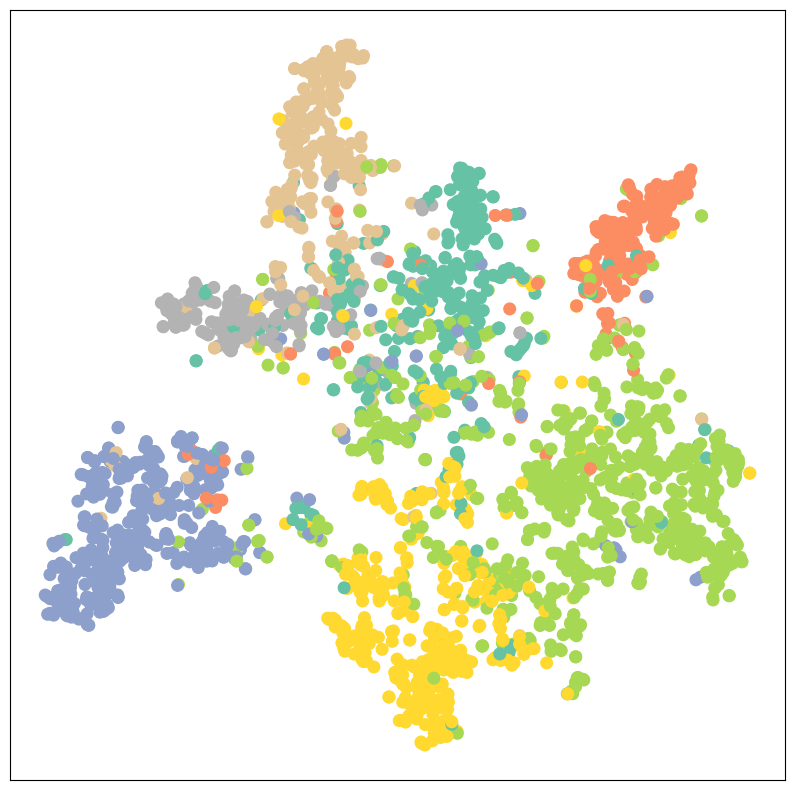

In [60]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

#**Canonical Featue + MLP**

In [61]:
X_Train=data.x[data.train_mask]
Y_Train=data.y[data.train_mask]
X_Test=data.x[data.test_mask]
Y_Test=data.y[data.test_mask]

In [62]:

input_data=data.x
input_data=input_data.float()

model = MLP(input_data.shape[1],hidden_channels=16)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 120):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'MLP Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


# **Canonical Featue + RandomForest**

In [63]:
rf_clf = RandomForestClassifier(criterion='entropy')
rf_clf.fit(X_Train,Y_Train)
y_predict = rf_clf.predict(X_Test)

print("RandromForest Accuracy:", accuracy_score(Y_Test,y_predict))


RandromForest Accuracy: 0.556


#**PCA + GNN**

In [64]:
X = data.x
pca = PCA(n_components=15)
data_PCA=pca.fit_transform(X)

In [65]:

input_data=torch.tensor(data_PCA)
input_data=input_data.float()

model = GCN(input_data.shape[1],hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(input_data, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(input_data, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 300):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9458
Epoch: 002, Loss: 1.9426
Epoch: 003, Loss: 1.9382
Epoch: 004, Loss: 1.9388
Epoch: 005, Loss: 1.9364
Epoch: 006, Loss: 1.9362
Epoch: 007, Loss: 1.9321
Epoch: 008, Loss: 1.9337
Epoch: 009, Loss: 1.9307
Epoch: 010, Loss: 1.9299
Epoch: 011, Loss: 1.9268
Epoch: 012, Loss: 1.9294
Epoch: 013, Loss: 1.9211
Epoch: 014, Loss: 1.9205
Epoch: 015, Loss: 1.9189
Epoch: 016, Loss: 1.9205
Epoch: 017, Loss: 1.9207
Epoch: 018, Loss: 1.9187
Epoch: 019, Loss: 1.9144
Epoch: 020, Loss: 1.9098
Epoch: 021, Loss: 1.9108
Epoch: 022, Loss: 1.8998
Epoch: 023, Loss: 1.9067
Epoch: 024, Loss: 1.9136
Epoch: 025, Loss: 1.8890
Epoch: 026, Loss: 1.8931
Epoch: 027, Loss: 1.8878
Epoch: 028, Loss: 1.8963
Epoch: 029, Loss: 1.8915
Epoch: 030, Loss: 1.8736
Epoch: 031, Loss: 1.8795
Epoch: 032, Loss: 1.8733
Epoch: 033, Loss: 1.8763
Epoch: 034, Loss: 1.8705
Epoch: 035, Loss: 1.8615
Epoch: 036, Loss: 1.8694
Epoch: 037, Loss: 1.8637
Epoch: 038, Loss: 1.8597
Epoch: 039, Loss: 1.8531
Epoch: 040, Loss: 1.8449


#PCA + MLP

In [66]:
X_Train=data_PCA[data.train_mask]
Y_Train=data.y[data.train_mask]
X_Test=data_PCA[data.test_mask]
Y_Test=data.y[data.test_mask]

In [67]:
input_data=torch.tensor(data_PCA)
input_data=input_data.float()

model = MLP(input_data.shape[1],hidden_channels=16)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(input_data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(input_data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 300):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'MLP Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9496
Epoch: 002, Loss: 1.9538
Epoch: 003, Loss: 1.9481
Epoch: 004, Loss: 1.9515
Epoch: 005, Loss: 1.9423
Epoch: 006, Loss: 1.9501
Epoch: 007, Loss: 1.9492
Epoch: 008, Loss: 1.9481
Epoch: 009, Loss: 1.9487
Epoch: 010, Loss: 1.9406
Epoch: 011, Loss: 1.9404
Epoch: 012, Loss: 1.9384
Epoch: 013, Loss: 1.9440
Epoch: 014, Loss: 1.9399
Epoch: 015, Loss: 1.9428
Epoch: 016, Loss: 1.9390
Epoch: 017, Loss: 1.9366
Epoch: 018, Loss: 1.9382
Epoch: 019, Loss: 1.9330
Epoch: 020, Loss: 1.9349
Epoch: 021, Loss: 1.9384
Epoch: 022, Loss: 1.9298
Epoch: 023, Loss: 1.9352
Epoch: 024, Loss: 1.9361
Epoch: 025, Loss: 1.9305
Epoch: 026, Loss: 1.9268
Epoch: 027, Loss: 1.9377
Epoch: 028, Loss: 1.9321
Epoch: 029, Loss: 1.9315
Epoch: 030, Loss: 1.9198
Epoch: 031, Loss: 1.9368
Epoch: 032, Loss: 1.9280
Epoch: 033, Loss: 1.9231
Epoch: 034, Loss: 1.9301
Epoch: 035, Loss: 1.9193
Epoch: 036, Loss: 1.9103
Epoch: 037, Loss: 1.9109
Epoch: 038, Loss: 1.9258
Epoch: 039, Loss: 1.9172
Epoch: 040, Loss: 1.9088


# **PCA + RandomForest**

In [68]:
rf_clf = RandomForestClassifier(criterion='entropy')
rf_clf.fit(X_Train,Y_Train)
y_predict = rf_clf.predict(X_Test)
print("RandromForest Accuracy:", accuracy_score(Y_Test,y_predict))


RandromForest Accuracy: 0.481




#**One-Hot + GNN**


In [69]:
data_ind=torch.tensor(np.asarray(range(data.x.shape[0])))
data_one_hot = torch.nn.functional.one_hot(data_ind, num_classes=data_ind.shape[0])

In [70]:
input_data=data_one_hot
input_data=input_data.float()

model = GCN(input_data.shape[1],hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(input_data, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(input_data, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 300):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9351
Epoch: 003, Loss: 1.9183
Epoch: 004, Loss: 1.8951
Epoch: 005, Loss: 1.8733
Epoch: 006, Loss: 1.8458
Epoch: 007, Loss: 1.8178
Epoch: 008, Loss: 1.7871
Epoch: 009, Loss: 1.7556
Epoch: 010, Loss: 1.7290
Epoch: 011, Loss: 1.6768
Epoch: 012, Loss: 1.6500
Epoch: 013, Loss: 1.6124
Epoch: 014, Loss: 1.5802
Epoch: 015, Loss: 1.5317
Epoch: 016, Loss: 1.5015
Epoch: 017, Loss: 1.4546
Epoch: 018, Loss: 1.4212
Epoch: 019, Loss: 1.3441
Epoch: 020, Loss: 1.3152
Epoch: 021, Loss: 1.2601
Epoch: 022, Loss: 1.2237
Epoch: 023, Loss: 1.1943
Epoch: 024, Loss: 1.1326
Epoch: 025, Loss: 1.0941
Epoch: 026, Loss: 1.0663
Epoch: 027, Loss: 0.9764
Epoch: 028, Loss: 0.9750
Epoch: 029, Loss: 0.9217
Epoch: 030, Loss: 0.8895
Epoch: 031, Loss: 0.8713
Epoch: 032, Loss: 0.8202
Epoch: 033, Loss: 0.7392
Epoch: 034, Loss: 0.7215
Epoch: 035, Loss: 0.6743
Epoch: 036, Loss: 0.6598
Epoch: 037, Loss: 0.6422
Epoch: 038, Loss: 0.5998
Epoch: 039, Loss: 0.5638
Epoch: 040, Loss: 0.5415


#**One-Hot + MLP**

In [71]:
X_Train=data_one_hot[data.train_mask]
Y_Train=data.y[data.train_mask]
X_Test=data_one_hot[data.test_mask]
Y_Test=data.y[data.test_mask]

In [72]:

input_data=data_one_hot
input_data=input_data.float()

model = MLP(input_data.shape[1],hidden_channels=16)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(input_data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(input_data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 300):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'MLP Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 1.9559
Epoch: 002, Loss: 1.9501
Epoch: 003, Loss: 1.9419
Epoch: 004, Loss: 1.9328
Epoch: 005, Loss: 1.9196
Epoch: 006, Loss: 1.9070
Epoch: 007, Loss: 1.8907
Epoch: 008, Loss: 1.8757
Epoch: 009, Loss: 1.8524
Epoch: 010, Loss: 1.8269
Epoch: 011, Loss: 1.8095
Epoch: 012, Loss: 1.7694
Epoch: 013, Loss: 1.7655
Epoch: 014, Loss: 1.7263
Epoch: 015, Loss: 1.6903
Epoch: 016, Loss: 1.6498
Epoch: 017, Loss: 1.6583
Epoch: 018, Loss: 1.5848
Epoch: 019, Loss: 1.5715
Epoch: 020, Loss: 1.5197
Epoch: 021, Loss: 1.4612
Epoch: 022, Loss: 1.4425
Epoch: 023, Loss: 1.3916
Epoch: 024, Loss: 1.3687
Epoch: 025, Loss: 1.3153
Epoch: 026, Loss: 1.2281
Epoch: 027, Loss: 1.2561
Epoch: 028, Loss: 1.2041
Epoch: 029, Loss: 1.1380
Epoch: 030, Loss: 1.1260
Epoch: 031, Loss: 1.0266
Epoch: 032, Loss: 1.0074
Epoch: 033, Loss: 0.9561
Epoch: 034, Loss: 0.9179
Epoch: 035, Loss: 0.8687
Epoch: 036, Loss: 0.8885
Epoch: 037, Loss: 0.8271
Epoch: 038, Loss: 0.7770
Epoch: 039, Loss: 0.7642
Epoch: 040, Loss: 0.7457


#**One-Hot + Random Forest**

In [73]:
rf_clf = RandomForestClassifier(criterion='entropy')
rf_clf.fit(X_Train,Y_Train)
y_predict = rf_clf.predict(X_Test)


print("RandromForest Accuracy:", accuracy_score(Y_Test,y_predict))


RandromForest Accuracy: 0.319


# **Index + GNN**

In [74]:
data_index=torch.tensor(np.asarray(range(data.x.shape[0])))
data_index=torch.reshape(data_index, (data_index.shape[0], 1))

In [75]:
data_index.shape

torch.Size([2708, 1])

In [76]:
input_data=data_index
input_data=input_data.float()

model = GCN(input_data.shape[1],hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(input_data, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def train_test_acc():
      model.eval()
      out = model(input_data, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.

      train_correct = pred[data.train_mask] == data.y[data.train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  # Derive ratio of correct predictions.

      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return train_acc,test_acc



train_acc_list=[]
test_acc_list=[]
for epoch in range(1, 120):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_acc,test_acc = train_test_acc()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)


print(f'Test Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 488.7865
Epoch: 002, Loss: 444.4986
Epoch: 003, Loss: 437.4409
Epoch: 004, Loss: 395.9414
Epoch: 005, Loss: 383.7472
Epoch: 006, Loss: 311.7961
Epoch: 007, Loss: 329.7555
Epoch: 008, Loss: 294.1515
Epoch: 009, Loss: 259.1042
Epoch: 010, Loss: 240.9425
Epoch: 011, Loss: 218.5743
Epoch: 012, Loss: 201.7167
Epoch: 013, Loss: 221.6903
Epoch: 014, Loss: 214.6572
Epoch: 015, Loss: 161.2284
Epoch: 016, Loss: 165.5439
Epoch: 017, Loss: 156.0957
Epoch: 018, Loss: 156.3220
Epoch: 019, Loss: 127.2226
Epoch: 020, Loss: 141.4782
Epoch: 021, Loss: 126.9738
Epoch: 022, Loss: 123.2595
Epoch: 023, Loss: 110.9511
Epoch: 024, Loss: 101.8054
Epoch: 025, Loss: 95.0045
Epoch: 026, Loss: 96.7572
Epoch: 027, Loss: 97.3805
Epoch: 028, Loss: 81.3175
Epoch: 029, Loss: 90.9349
Epoch: 030, Loss: 79.8992
Epoch: 031, Loss: 72.4179
Epoch: 032, Loss: 87.7658
Epoch: 033, Loss: 65.0062
Epoch: 034, Loss: 51.7215
Epoch: 035, Loss: 56.5744
Epoch: 036, Loss: 62.3647
Epoch: 037, Loss: 58.3981
Epoch: 038, Lo

# **Index + MLP**

In [77]:
X_Train=data_index[data.train_mask]
Y_Train=data.y[data.train_mask]
X_Test=data_index[data.test_mask]
Y_Test=data.y[data.test_mask]

In [78]:
input_data=data_index
input_data=input_data.float()

model = MLP(input_data.shape[1],hidden_channels=16)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(input_data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(input_data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 120):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

test_acc = test()
print(f'MLP Accuracy: {test_acc:.4f}')

Epoch: 001, Loss: 30.6952
Epoch: 002, Loss: 29.9328
Epoch: 003, Loss: 22.1395
Epoch: 004, Loss: 20.5358
Epoch: 005, Loss: 19.7634
Epoch: 006, Loss: 19.9377
Epoch: 007, Loss: 14.4692
Epoch: 008, Loss: 15.4242
Epoch: 009, Loss: 14.1723
Epoch: 010, Loss: 12.0735
Epoch: 011, Loss: 13.4201
Epoch: 012, Loss: 12.3760
Epoch: 013, Loss: 10.1923
Epoch: 014, Loss: 10.8941
Epoch: 015, Loss: 10.1470
Epoch: 016, Loss: 8.9146
Epoch: 017, Loss: 7.1323
Epoch: 018, Loss: 6.4002
Epoch: 019, Loss: 6.9465
Epoch: 020, Loss: 6.2958
Epoch: 021, Loss: 4.7507
Epoch: 022, Loss: 4.9685
Epoch: 023, Loss: 4.5385
Epoch: 024, Loss: 3.9720
Epoch: 025, Loss: 3.2824
Epoch: 026, Loss: 3.0384
Epoch: 027, Loss: 3.2467
Epoch: 028, Loss: 2.9024
Epoch: 029, Loss: 2.7257
Epoch: 030, Loss: 2.7151
Epoch: 031, Loss: 2.4631
Epoch: 032, Loss: 2.6459
Epoch: 033, Loss: 2.6601
Epoch: 034, Loss: 2.6666
Epoch: 035, Loss: 2.4531
Epoch: 036, Loss: 2.4775
Epoch: 037, Loss: 2.1933
Epoch: 038, Loss: 2.3586
Epoch: 039, Loss: 2.4206
Epoch: 040

# **Index + RandomForest**

In [79]:
rf_clf = RandomForestClassifier(criterion='entropy')
rf_clf.fit(X_Train,Y_Train)

y_train_prdict=rf_clf.predict(X_Train)
y_predict = rf_clf.predict(X_Test)

print("RandromForest Train Accuracy:", accuracy_score(Y_Train,y_train_prdict))
print("RandromForest Test Accuracy:", accuracy_score(Y_Test,y_predict))


RandromForest Train Accuracy: 1.0
RandromForest Test Accuracy: 0.091
